# Radial Velocity Method 

We will first use NEID data to understand the principle.

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import copy
from astropy.io import fits
import radvel

/home/hbcse/Desktop/NIUS_Astronomy_workshop/exoplanet/env/lib/python3.10/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


In [2]:
# Load one NEID solar spectrum
# Based on https://github.com/arpita308/NEID_Tutorials
# https://neid.ipac.caltech.edu/search_solar.php
hdul = fits.open('neidL2_20210208T191024.fits')
hdul.info()

Filename: neidL2_20210208T191024.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     740   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float32   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float32   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float32   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2253   (9216, 122)   float64   
 10  TELLURIC      1 ImageHDU        12   (9216, 122)   float64   
 11  SKY           1 ImageHDU         8   ()      
 12  CCFS          1 ImageHDU       515   (804, 122)   float64   
 13  ACTIVITY      1 BinTableHDU     41   15R x 12C   [10A, D,

<IPython.core.display.Javascript object>


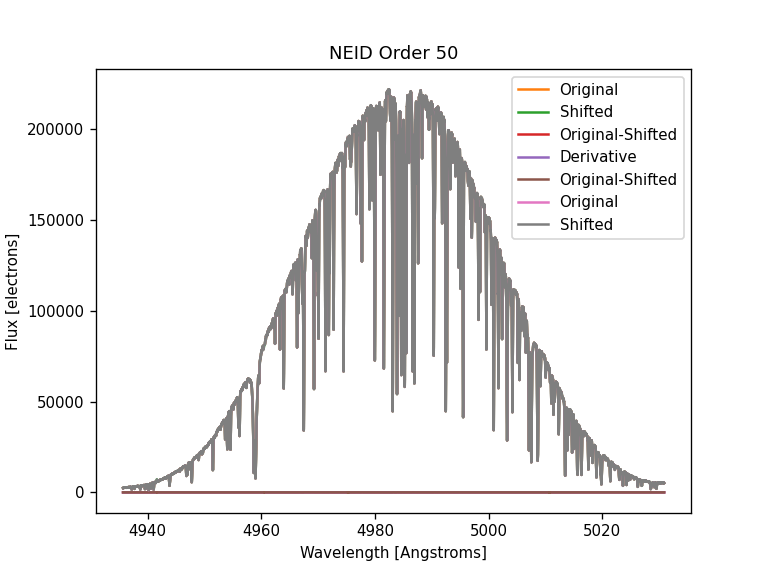

In [10]:
# Plot the spectrum
%matplotlib notebook
order=50
    
plt.plot(hdul['SCIWAVE'].data[order],hdul['SCIFLUX'].data[order])
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.show()

In [12]:
from scipy import interpolate
interpolate.interpld?

Object `interpolate.interpld` not found.


In [17]:
# Artifically doppler shift the spectrum
from scipy import interpolate
from scipy.constants import speed_of_light
dopplerfactor = 1 + 1./speed_of_light  # 1m/s
gm = np.isfinite(hdul['SCIFLUX'].data[order])
shifted_spectrum = interpolate.interp1d(hdul['SCIWAVE'].data[order][gm]*dopplerfactor, 
                         hdul['SCIFLUX'].data[order][gm],kind="cubic",fill_value="extrapolate")(hdul['SCIWAVE'].data[order])

In [20]:
dopplerfactor


1.0000000033356409

<IPython.core.display.Javascript object>


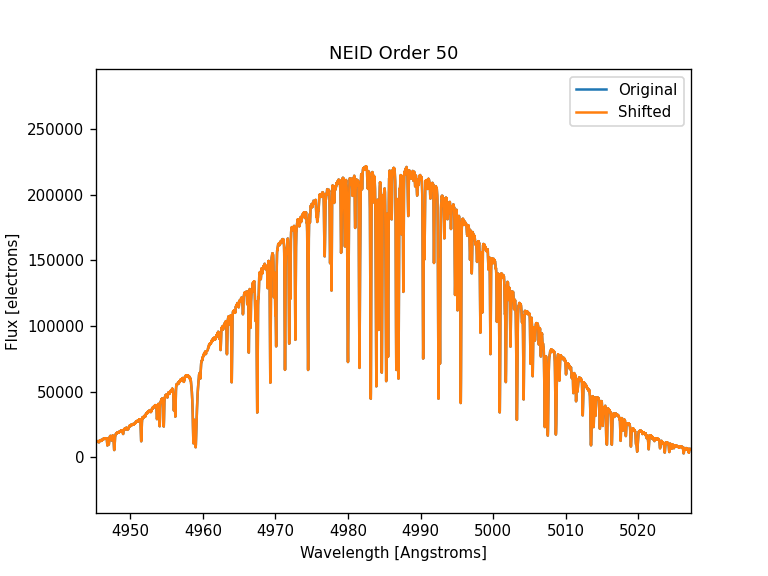

In [21]:
#Plot and compare
plt.plot(hdul['SCIWAVE'].data[order],hdul['SCIFLUX'].data[order],label="Original")
plt.plot(hdul['SCIWAVE'].data[order],shifted_spectrum,label="Shifted")
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


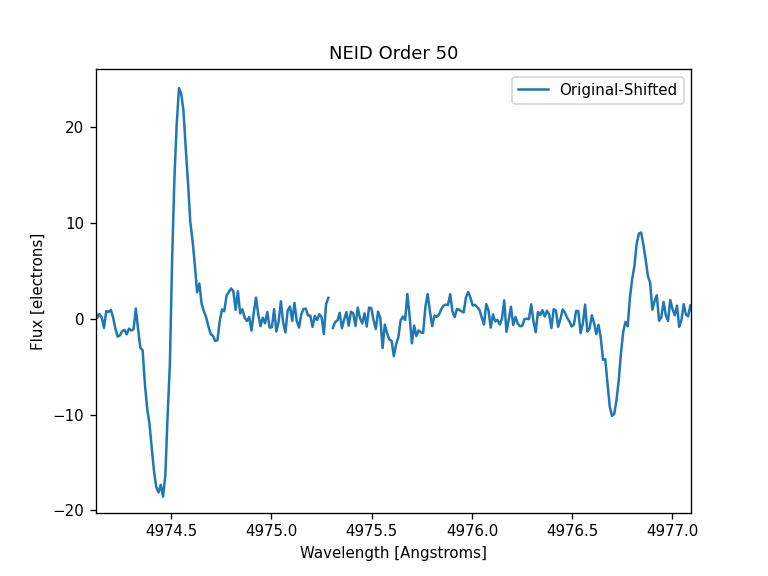

In [23]:
# Plot the difference
plt.plot(hdul['SCIWAVE'].data[order],hdul['SCIFLUX'].data[order]-shifted_spectrum,label="Original-Shifted")
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


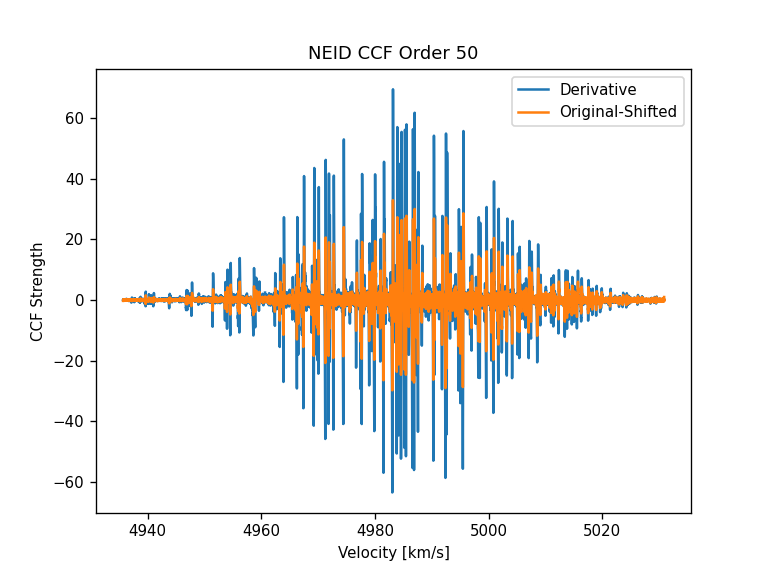

In [24]:
# Compare to Derivative
plt.plot(hdul['SCIWAVE'].data[order],np.gradient(hdul['SCIFLUX'].data[order])/300.,label="Derivative")
plt.plot(hdul['SCIWAVE'].data[order],hdul['SCIFLUX'].data[order]-shifted_spectrum,label="Original-Shifted")
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.legend()
plt.show()

# Theoretical limit to measurable velocity precision
https://ui.adsabs.harvard.edu/abs/2001A&A...374..733B/abstract

# CCF
https://neid.ipac.caltech.edu/docs/NEID-DRP/_images/ccf_fitting.png

In [25]:
hdul['CCFS'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  804                                                  
NAXIS2  =                  122                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
CTYPE1  = 'km/s    '           / Pixel coordinate system in x                   
CTYPE2  = 'e-      '           / Pixel coordinate system in y                   
CCFSTART=               -100.0 / Start of RV range (km/s)                       
CCFSTEP =                 0.25 / Step of RV range (km/s)                        
MAXCPP  =    5010849.664593624 / Max count/pixel of CCF)                        
CCFLINES=                 55

In [26]:
# Nicely formatted print statements
print('Radial velocity of this observation is {} km/s.'.format(hdul['CCFS'].header['CCFRVMOD']))
print('Time of this observation is {} BJD.'.format(hdul['CCFS'].header['CCFJDMOD']))

Radial velocity of this observation is -0.6403652439391726 km/s.
Time of this observation is 2459254.294322899 BJD.


In [27]:
# These are the header keywords we will need to plot the CCF
ccfstart = float(hdul['CCFS'].header['CCFSTART'])
ccfstep = float(hdul['CCFS'].header['CCFSTEP'])
npixels = float(hdul['CCFS'].header['NAXIS1'])
gamma_rv = float(hdul[0].header['QRV'])

print('Start of x-axis velocity array:',ccfstart)
print('Step size of x-axis velocity array:',ccfstep)
print('Length of x-axis velocity array:',npixels)
print('Rough average velocity of star:',gamma_rv)  # --> Will be 0 for the Sun

Start of x-axis velocity array: -100.0
Step size of x-axis velocity array: 0.25
Length of x-axis velocity array: 804.0
Rough average velocity of star: 0.0


<IPython.core.display.Javascript object>


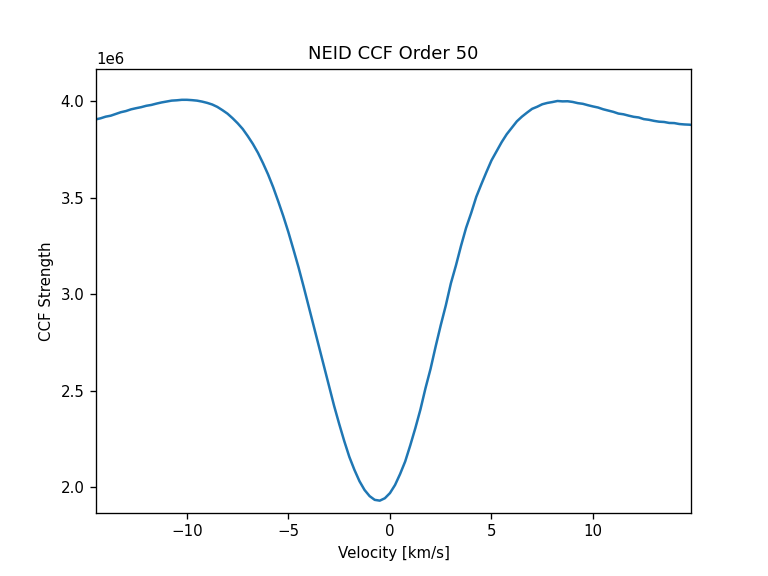

In [29]:
velocity_loop = (np.arange(npixels)*ccfstep) + ccfstart + gamma_rv
plt.plot(velocity_loop,hdul['CCFS'].data[order])
plt.title('NEID CCF Order {}'.format(order))
plt.xlabel('Velocity [km/s]')
plt.ylabel('CCF Strength')
plt.show()

# Keplerian Model fitting to Radial velocity data

In [30]:
# Based on https://github.com/California-Planet-Search/radvel/blob/master/docs/tutorials/SyntheticData.ipynb
# Intialize Keplerian model parameters
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.6)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

In [31]:
# Generate Synthetic Data
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
jitter = 0.3
syn_rv = rv_mod(t) + np.random.random(t.size)*np.sqrt(errvel**2 + jitter**2)

<IPython.core.display.Javascript object>


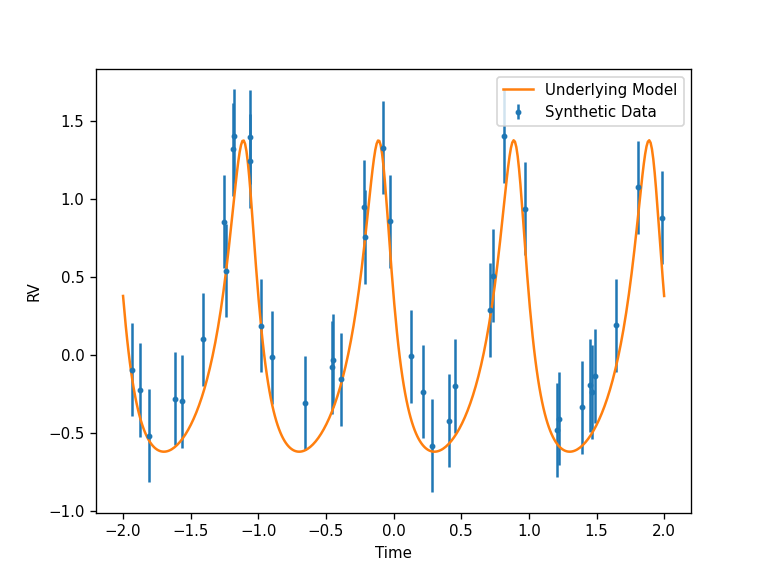

In [32]:
# Plot the Synthetic Data
plt.errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plt.plot(ti,rv_mod(ti),label='Underlying Model')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend()
plt.show()

In [35]:
# Generate a likelihood
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,np.zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter


In [36]:
#Perform a maximum likelihood fit
print('Starting Guess:',like_syn.get_vary_params())
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)

Starting Guess: [1.  0.1 0.1 0.1 3.  0. ]
 final_simplex: (array([[ 1.00764795,  0.00850615,  0.54299576,  0.3138022 ,  1.02065274,
         0.16799261],
       [ 1.00438521, -0.00592476,  0.58958837,  0.32909011,  1.0809533 ,
         0.16131836],
       [ 1.002747  ,  0.00244349,  0.55044661,  0.37158896,  1.00573851,
         0.17293397],
       [ 1.00173519,  0.00684715,  0.52607105,  0.37668204,  1.00160128,
         0.16375957],
       [ 1.00196003,  0.00253678,  0.57262868,  0.32689133,  0.99021062,
         0.15092424],
       [ 1.00439667,  0.00184902,  0.54528131,  0.34782759,  1.01542769,
         0.129341  ],
       [ 1.00121717,  0.01336537,  0.51718523,  0.3602033 ,  0.96776978,
         0.13912497]]), array([4.91524648, 5.05859809, 5.14314725, 5.16978661, 5.32240145,
       5.443831  , 5.58398185]))
           fun: 4.91524648311788
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1200
           nit: 803
        status: 1
      

<IPython.core.display.Javascript object>


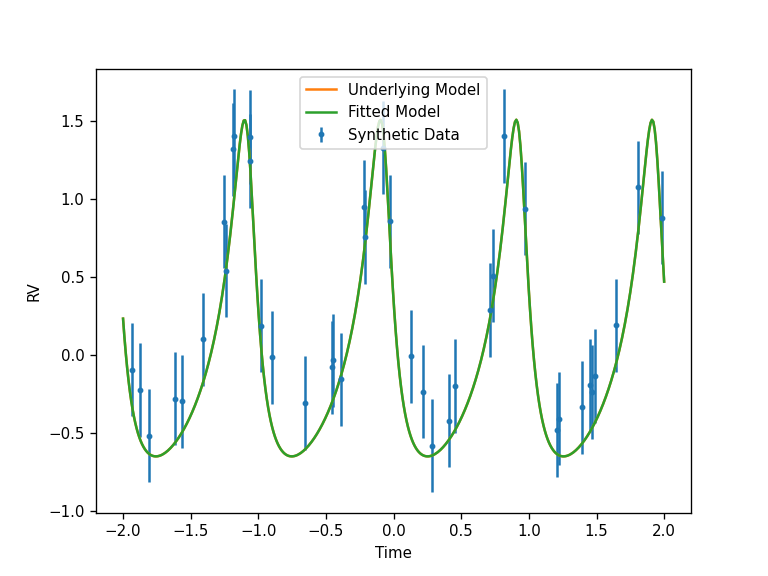

In [37]:
plt.errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plt.plot(ti,rv_mod(ti),label='Underlying Model')
plt.plot(ti,like_syn.model(ti),label='Fitted Model')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend()
plt.show()

In [38]:
# Instantiate a posterior object
post = radvel.posterior.Posterior(like_syn)
post.params['per1'] = radvel.Parameter(value=1)
post.params['k1'] = radvel.Parameter(value=1)
post.params['jit'].vary = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post)

parameter                     value      vary
per1                              1       True
tc1                             0.1       True
secosw1                         0.1       True
sesinw1                         0.1       True
k1                                3       True
gamma                             0       True
jit                             0.3       True
tp1                      -0.0205459           
e1                             0.02           
w1                         0.785398           

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



In [39]:
# Perform maximum likelihood fit on posterior
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )

<IPython.core.display.Javascript object>


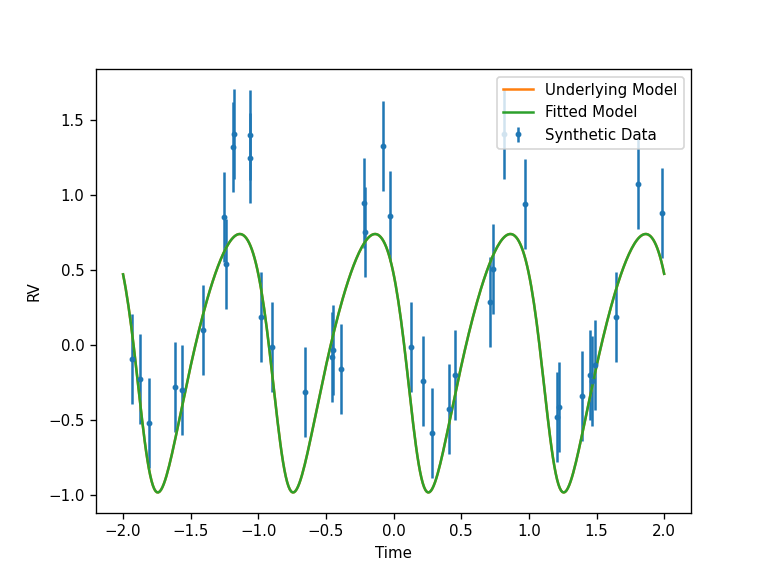

In [44]:
plt.errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plt.plot(ti,rv_mod(ti),label='Underlying Model')
plt.plot(ti,post.likelihood.model(ti),label='Fitted Model')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend()
plt.show()

In [45]:
#Use mcmc to sample the posterior distribution
df = radvel.mcmc(post,nwalkers=20,nrun=1000)#,savename='rawchain.h5')

AttributeError: module 'numpy.__config__' has no attribute 'blas_opt_info'

In [43]:
# Plot the corner plot
import corner
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
            df[labels],
            labels=labels,
            truths=[truths[k].value for k in labels ],
            quantiles=[0.15,0.85],
            plot_datapoints=False,
            smooth=True,
            bins=20
            )

NameError: name 'df' is not defined